# Email Spam Classification

### Author: Ruchita Nagare


## Clustering emails using Gaussian Mixture Models

For this problem, we will be analyzing emails taken from the [Enron Email Dataset](https://www.cs.cmu.edu/~enron/). We have already curated the data for you in the `data/enron` directory, with one file per email (so there is no need to redownload the dataset as it is already included in this homework zip archive). The dataset includes a combination of "spam" and "ham" emails. Spam emails are unsolicited messages intended to sell a product or scam users into providing personal information, while ham emails represent everything that is not spam.

The language used in spam emails tends to be considerably different from typical business emails. Most spam filters leverage this difference in word frequencies to detect spam as it arrives and filter it out of email inboxes. We will use Gaussian Mixture Models (GMMs) to cluster the emails and attempt to identify groups of emails which are likely to be spam.

### Part A: Construct a list of processed documents

Below is a function that returns a document present in a file given a filename. The function performs some preprocessing to (1) remove punctuation, (2),(3) remove whitespace and (4) lowercase all words. 

In [1]:
import re
import string
import codecs

def make_word_list(path):
    
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*', '', corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]', '', text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [2]:
import glob

processed_docs = []
for i in (glob.glob('./data/enron/*.txt')):
    li = make_word_list(i)
    processed_docs.append(li)

### Part B: Constructing a document matrix 

Next, we construct a document matrix `X` as a matrix of [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) features for each document. TF-IDF features encode information about the word frequency within a document, weighted by the frequency of the same word for corpus as a whole.


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df = 50,
                            max_df = 0.8,
                            stop_words = "english")
X = vectorizer.fit_transform(processed_docs)

vocabulary = vectorizer.vocabulary_

print("Number of unique words in the vocabulary:", len(vocabulary))

Number of unique words in the vocabulary: 1680


### Part C: Perform Clustering 

In [4]:
from sklearn.mixture import GaussianMixture
from collections import Counter


gmm = GaussianMixture(n_components=3, random_state = 0)
gmm.fit(X.toarray())
gmm_cluster_assignments = gmm.predict(X.toarray())

#Printing the number of documents assigned to each cluster
cluster_counter = Counter()

for i in gmm_cluster_assignments:
    cluster_counter[i] += 1
    
for cluster, count in cluster_counter.most_common():
    print("Cluster", cluster , ": ", count)

Cluster 2 :  2933
Cluster 1 :  1875
Cluster 0 :  363


### Part D: Characterize the clusters

Now, we will attempt to characterize the clusters based on the frequency of spam-relevant words. 
- Select 3 "spammy" words from the vocabulary that you expect to occur frequently in spam emails and less frequently in normal business emails (e.g., 'click', 'www', 'offer'). Construct a list, `spam_indices`, storing the indices of the spammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Select 3 "hammy" words from the vocabulary you think will occur frequently in business emails and infrequently in spam emails (e.g., 'meeting', 'attached', 'review'). Construct a list, `ham_indices`, storing the indices of the hammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Use the function provided below, `plot_spam_words_by_cluster`, to plot the average TF-IDF features for your selected spammy words and hammy words for each cluster. The function takes the following parameters:
    - `X` is a matrix of TF-IDF features (rows index documents, columns index terms).
    - `predicted` is predicted cluster assignments returned by `GaussianMixture.predict()`
    - `n_clusters` is the number of clusters. This should match the number of clusters from your GMM.
    - `spam_indices` is a list of indices of spammy words in the vocabulary.
    - `ham_indices` is a list of indices of hammy (typical business) words in the vocabulary.

In [5]:
# unsubrscribe, click, congratulations, membership, www, com, http, review, win, url, subscription

In [6]:
def plot_spam_words_by_cluster(X, predicted, n_clusters, spam_indices, ham_indices):
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Calculate mean TF-IDF features for each cluster
    mean_tfidf_spam = []
    mean_tfidf_ham = []
    for spam in spam_indices:
        mean_tfidf_spam.append([])
    for ham in ham_indices:
        mean_tfidf_ham.append([])
    
    for i in range(n_clusters):
        for j, spam_idx in enumerate(spam_indices):
            mean_tfidf_spam[j].append(X[predicted==i, spam_idx].mean())
        for j, ham_idx in enumerate(ham_indices):
            mean_tfidf_ham[j].append(X[predicted==i, ham_idx].mean())
    
    # Generate plot
    fig, ax = plt.subplots()

    ind = np.arange(n_clusters)    # the x locations for the groups
    width = 0.10         # the width of the bars

    # Plot spam bars
    for i, val in enumerate(mean_tfidf_spam):
        spam_bar = ax.bar(ind - (len(mean_tfidf_spam)-i-1)*width, val, width, color='r', bottom=0)

    # Plot ham bars
    for i, val in enumerate(mean_tfidf_ham):
        ham_bar = ax.bar(ind + (len(mean_tfidf_ham)-i)*width, val, width,
                color='y', bottom=0)

    ax.set_title('Mean TF-IDF Features by Cluster for Spam-Relevant Words')
    ax.set_xticks(ind + width / 2)
    xticklabels = []
    for i in range(n_clusters):
        xticklabels.append('Cluster ' + str(i) + '\n(n=' + str((predicted==i).sum()) + ')')
    ax.set_xticklabels(xticklabels)

    ax.legend((spam_bar[0], ham_bar[0]), ('Spammy words', 'Hammy words'))
    ax.autoscale_view()
    ax.set_ylabel('Mean TF-IDF')
    plt.show()

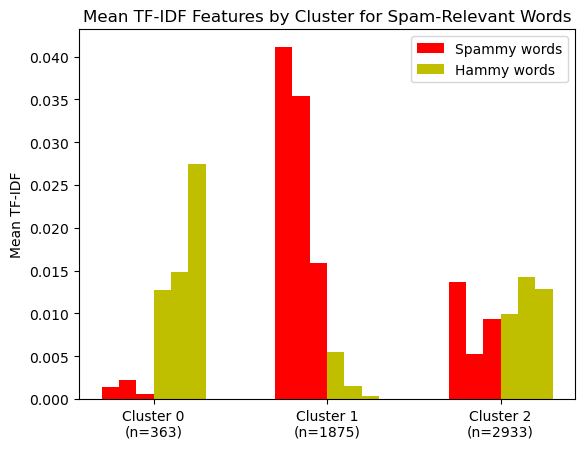

In [7]:
spammy_words = ['click', 'www', 'offer']
spammy_indices = []
hammy_words = ['meeting', 'attached', 'review']
hammy_indices = []

for word in spammy_words:
    spammy_indices.append(vocabulary[word])

for word in hammy_words:
    hammy_indices.append(vocabulary[word])
    
plot_spam_words_by_cluster(X, gmm_cluster_assignments, 3, spammy_indices, hammy_indices)

### Part E: Interpret results

Let's try to get some insights by addressing the following questions:
From the plot generated in part (d), do any of the clusters correspond to spam emails, based on the frequency of spammy and hammy words? Do any of the clusters appear to correspond to typical business emails (ham)? 

Re-run your analysis with a different choice for the number of clusters in your GMM (e.g., `n_clusters=5` or `n_clusters=2`). How does changing the number of clusters affect your results? Does one choice of `n_clusters` appear better than another for locating clusters of spam emails?

***Cluster 1 corresponds to spam emails.***

***Cluster 0 corresponds to  typical business emails (ham)***

***Cluster 2 though seems ambiguous***

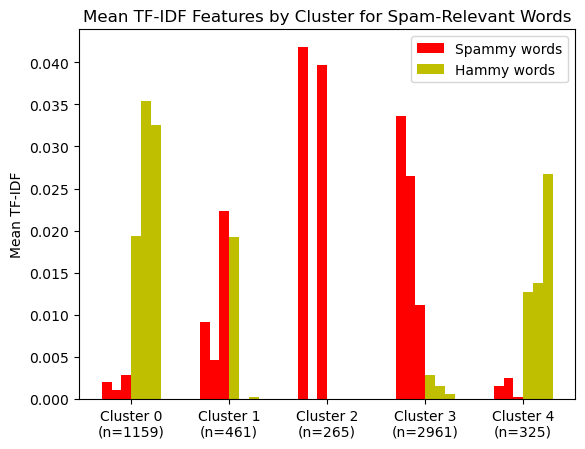

In [8]:
gmm2 = GaussianMixture(n_components=5, random_state = 0)
gmm2.fit(X.toarray())
gmm2_cluster_assignments = gmm2.predict(X.toarray())
plot_spam_words_by_cluster(X, gmm2_cluster_assignments, 5, spammy_indices, hammy_indices)


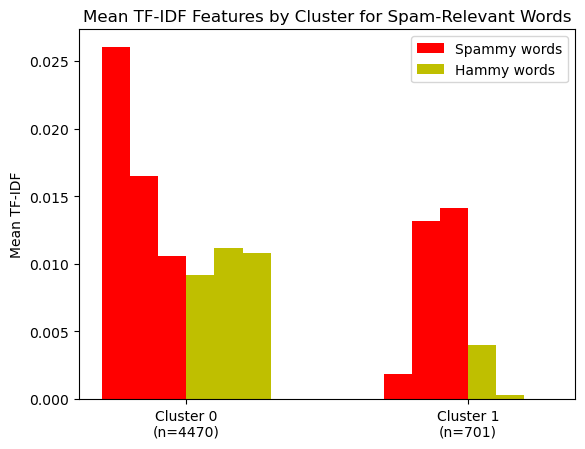

In [9]:
gmm3 = GaussianMixture(n_components=2, random_state = 0)
gmm3.fit(X.toarray())
gmm3_cluster_assignments = gmm3.predict(X.toarray())
plot_spam_words_by_cluster(X, gmm3_cluster_assignments, 2, spammy_indices, hammy_indices)

***Here we can observe different results by changing the number of clusters.***

***n_clusters = 5 --> This case seems to identify ham and spam emails pretty well. Clusters 0 and 1 are predominantly hammy. Clusters 2 and 3 are primararily spammy. Cluster 1 seems a mix of both and ambiguous.***

***n_clusters = 2 --> This case does not identify the spam and ham emails well. Both the clusters are ambiguous and it is difficult to decipher anything distinctly.***

***Thus n_clusters = 5 performs better than n_clusters = 3 or 2. And n_clusters = 2 performs the worst.***
